In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X[:1200] / 255.0
y = y[:1200]

X = X.reshape(-1, 1, 28, 28).astype(np.float32)
le = LabelEncoder()
y = le.fit_transform(y).astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42)

In [ ]:
# Layers
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size):
        self.k = kernel_size
        self.W = np.random.randn(out_channels, in_channels, self.k, self.k) * 0.1
        self.b = np.zeros(out_channels)

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape
        out_H = H - self.k + 1
        out_W = W - self.k + 1
        out = np.zeros((N, self.W.shape[0], out_H, out_W))
        for n in range(N):
            for f in range(self.W.shape[0]):
                for i in range(out_H):
                    for j in range(out_W):
                        out[n, f, i, j] = np.sum(x[n, :, i:i+self.k, j:j+self.k] * self.W[f]) + self.b[f]
        return out

    def backward(self, d_out, lr):
        N, C, H, W = self.x.shape
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        dx = np.zeros_like(self.x)
        out_H = H - self.k + 1
        out_W = W - self.k + 1

        for n in range(N):
            for f in range(self.W.shape[0]):
                for i in range(out_H):
                    for j in range(out_W):
                        dW[f] += d_out[n, f, i, j] * self.x[n, :, i:i+self.k, j:j+self.k]
                        db[f] += d_out[n, f, i, j]
                        dx[n, :, i:i+self.k, j:j+self.k] += d_out[n, f, i, j] * self.W[f]

        self.W -= lr * dW
        self.b -= lr * db
        return dx

class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad, lr):
        return grad * self.mask

class MaxPool2D:
    def __init__(self, size):
        self.size = size

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape
        out_H, out_W = H // self.size, W // self.size
        out = np.zeros((N, C, out_H, out_W))
        self.argmax = np.zeros_like(out, dtype=int)
        for n in range(N):
            for c in range(C):
                for i in range(out_H):
                    for j in range(out_W):
                        patch = x[n, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size]
                        out[n, c, i, j] = np.max(patch)
                        self.argmax[n, c, i, j] = np.argmax(patch)
        return out

    def backward(self, grad, lr):
        N, C, H, W = self.x.shape
        dx = np.zeros_like(self.x)
        out_H, out_W = grad.shape[2], grad.shape[3]
        for n in range(N):
            for c in range(C):
                for i in range(out_H):
                    for j in range(out_W):
                        index = self.argmax[n, c, i, j]
                        h_idx, w_idx = divmod(index, self.size)
                        dx[n, c, i*self.size + h_idx, j*self.size + w_idx] = grad[n, c, i, j]
        return dx

class Flatten:
    def forward(self, x):
        self.orig_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, grad, lr):
        return grad.reshape(self.orig_shape)

class Dense:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.1
        self.b = np.zeros(out_dim)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad, lr):
        dW = self.x.T @ grad
        db = np.sum(grad, axis=0)
        dx = grad @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dx

class SoftmaxCrossEntropy:
    def forward(self, x, y):
        self.y = y
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        log_likelihood = -np.log(self.probs[np.arange(len(y)), y] + 1e-9)
        return np.mean(log_likelihood)

    def backward(self, _, lr):
        grad = self.probs
        grad[np.arange(len(self.y)), self.y] -= 1
        return grad / len(self.y)

In [ ]:
# Model
class CNN:
    def __init__(self):
        self.layers = [
            Conv2D(1, 8, 3),
            ReLU(),
            MaxPool2D(2),
            Conv2D(8, 16, 3),
            ReLU(),
            MaxPool2D(2),
            Flatten(),
            Dense(16 * 5 * 5, 64),
            ReLU(),
            Dense(64, 10)
        ]
        self.loss_fn = SoftmaxCrossEntropy()

    def forward(self, x, y):
        for layer in self.layers:
            if isinstance(layer, Dense) and x.ndim > 2:
                x = x.reshape(x.shape[0], -1)
            x = layer.forward(x)
        loss = self.loss_fn.forward(x, y)
        return x, loss

    def backward(self, lr):
        grad = self.loss_fn.backward(None, lr)
        for layer in reversed(self.layers):
            grad = layer.backward(grad, lr)

    def predict(self, x):
        for layer in self.layers:
            if isinstance(layer, Dense) and x.ndim > 2:
                x = x.reshape(x.shape[0], -1)
            x = layer.forward(x)
        return np.argmax(x, axis=1)

In [ ]:
# Training
model = CNN()
epochs = 5
batch_size = 20
lr = 0.01
train_losses = []
train_accuracies = []

for epoch in range(1, epochs + 1):
    perm = np.random.permutation(len(X_train))
    X_train = X_train[perm]
    y_train = y_train[perm]

    epoch_loss = 0
    correct = 0
    for i in range(0, len(X_train), batch_size):
        xb = X_train[i:i+batch_size]
        yb = y_train[i:i+batch_size]
        logits, loss = model.forward(xb, yb)
        pred = np.argmax(logits, axis=1)
        correct += np.sum(pred == yb)
        epoch_loss += loss
        model.backward(lr)

    acc = correct / len(X_train)
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {acc:.4f}")
    train_losses.append(epoch_loss)
    train_accuracies.append(acc)

Epoch 1, Loss: 114.4775, Accuracy: 0.2280
Epoch 2, Loss: 112.8592, Accuracy: 0.2830
Epoch 3, Loss: 110.6527, Accuracy: 0.3320
Epoch 4, Loss: 106.3505, Accuracy: 0.3630
Epoch 5, Loss: 96.4990, Accuracy: 0.4770


In [ ]:
# Test Accuracy
test_preds = model.predict(X_test)
test_acc = np.mean(test_preds == y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6300


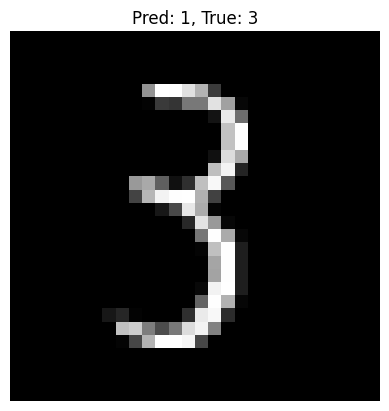

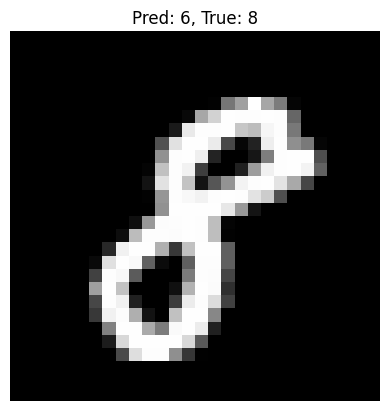

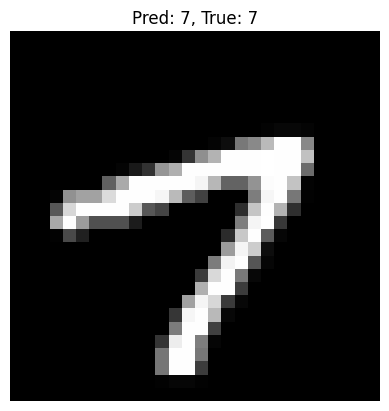

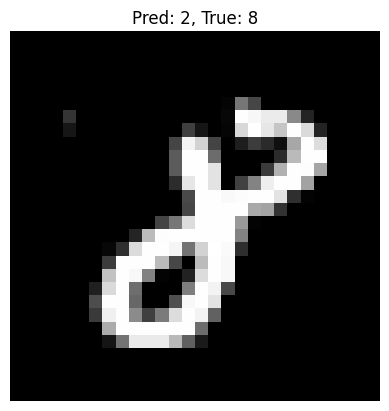

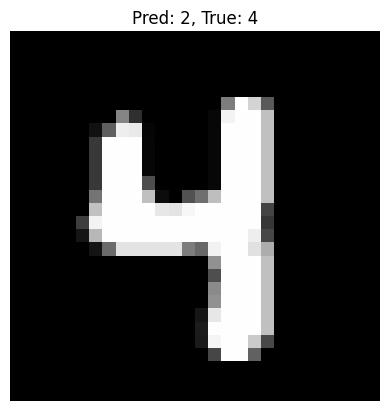

In [ ]:
# Visualization
def show_predictions(model, X, y_true, count=5):
    preds = model.predict(X[:count])
    for i in range(count):
        plt.imshow(X[i, 0], cmap='gray')
        plt.title(f"Pred: {preds[i]}, True: {y_true[i]}")
        plt.axis('off')
        plt.show()

show_predictions(model, X_test, y_test)

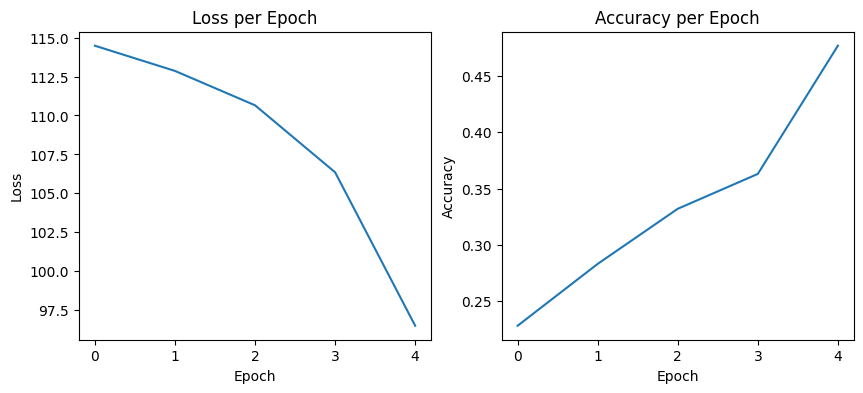

In [ ]:
# Plotting
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies)
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
